# LSTM Reduced Labels

In [1]:
import numpy as np
import pandas as pd
#for reading in data properly
import ast
import json

import gensim
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn import utils

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

### Load Data

In [2]:
all_data = pd.read_csv('train.csv')
all_data = all_data.dropna(subset=['overview', 'genres']) #drop cols without overview or genre (data we use or labels)

### Preprocess Data
<ul>
    <li>Get all possible genres.</li>
    <li>Vectorize Genres:</li>
    <ul>
        <li>Save genres as a vector of 0s and 1s.</li>
        <li>Save genres as list of strings.</li>
    </ul>
    <li>Process Overview Category</li>
    <ul>
        <li>Remove punctuation</li>
        <li>Set to lowercase</li>
    </ul>
</ul>

In [3]:
def text_to_list(x):
    if pd.isna(x):
        return ''
    else:
        return ast.literal_eval(x)

def parse_json(x):
    try:
        return json.loads(x.replace("'", '"'))[0]['name']
    except:
        return ''
    
def parse_genres_json(x):
    try:
        json_genres = json.loads(x.replace("'", '"'))
        numElems = len(json_genres)
        ret = [0]*len(genre_dict) #number of genres we are looking at
        for i in range(numElems):
            genre_str = (json_genres[i]['name'])
            if genre_str in genre_map.keys():
                ret[genre_dict[genre_map[genre_str]]] = 1
        return ret
    except Exception as excep:
        print('Exception' + str(excep))
        return ''

In [4]:
genre_dict = {}
genre_dict['Action-Adventure'] = 0
genre_dict['Romance'] = 1
genre_dict['Horror-Thriller'] = 2
genre_dict['Comedy'] = 3
genre_dict['Science Fiction'] = 4
genre_dict['Drama'] = 5
genre_dict

{'Action-Adventure': 0,
 'Romance': 1,
 'Horror-Thriller': 2,
 'Comedy': 3,
 'Science Fiction': 4,
 'Drama': 5}

In [5]:
genre_map = {}
genre_map['Adventure'] = 'Action-Adventure'
genre_map['Romance'] = 'Romance'
genre_map['Horror'] = 'Horror-Thriller'
genre_map['Thriller'] = 'Horror-Thriller'
genre_map['Comedy'] = 'Comedy'
#genre_map['War'] = 'Action-Adventure'#not sure about this
genre_map['Action'] = 'Action-Adventure'
genre_map['Science Fiction'] = 'Science Fiction'
genre_map['Fantasy'] = 'Science Fiction'
genre_map['Drama'] = 'Drama'

In [6]:
def getGenresVects():
    y = all_data['genres']
    ret = y.apply(parse_genres_json)
    all_data['genres_vect'] = ret
    return ret

In [7]:
labels_vects = getGenresVects() #get label vectors for genres indexed by indexes in genre_dict

In [8]:
#put to lower case, remove punctation
def cleanText(text):
    text = re.sub(r'[^a-z A-Z0-9]', "", text) #maybe shouldn't remove punction between words here?
    text = text.lower()
    return text
all_data['cleanOverview'] = all_data['overview'].apply(cleanText)

In [9]:
all_data = all_data[all_data.genres_vect.map(sum) > 0]

In [10]:
#logistic regression data
lr_data = all_data[['cleanOverview', 'genres_vect', 'overview']]

In [11]:
train, test = train_test_split(lr_data, test_size=0.2, random_state=42)

## LSTM 
<ul>
    <li>Get Word Embeddings</li>
    <li>Tokenize words</li>
    <li>Vectorize Overview</li>
</ul>

In [12]:
#get word embeddings
x = train['cleanOverview'].values.tolist()
y = train['genres_vect']

In [13]:
x_test = test['cleanOverview'].values.tolist()
y_test = test['genres_vect']

In [14]:
y_train = y.tolist()
y_train = np.array(y_train)

In [15]:
y_test = y_test.tolist()
y_test = np.array(y_test)

In [16]:
tok = [word_tokenize(sent) for sent in x]

In [17]:
word_vec_len = 32
model = Word2Vec(tok, min_count = 1, size=word_vec_len)

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

num_words_kept = 100000 #using 100000 most popular words, use throughout

tokenizer = Tokenizer(num_words_kept)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)

max_seq_len = 100

x_train_seq = pad_sequences(sequences, maxlen=max_seq_len)

Using TensorFlow backend.


In [19]:
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(test_sequences, maxlen=max_seq_len)

In [20]:
embeddings_index = {}
for w in model.wv.vocab.keys():
    embeddings_index[w] = model.wv[w]


embedding_matrix = np.zeros((num_words_kept, word_vec_len))
for word, i in tokenizer.word_index.items():
    if i >= num_words_kept:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Get Metrics
<ul>
    <li>Get accuracy, precision, recall for each genre.</li>
    <li>Get multi-label metrics.</li>
    <li>Compute hamming loss.</li>
    <li>Implement Delayed Early Stopping.</li>
</ul>

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def get_per_label_metrics(real_labels_matrix, predictions_labels_matrix):
    for genre in genre_dict.keys():
        index = genre_dict[genre]
        real_labels_vect = real_labels_matrix[:, index]
        prediction_vect = predictions_labels_matrix[:,index]
        print("Accuruacy for " + genre + ": " + str(accuracy_score(real_labels_vect, prediction_vect)))
        print("Precision for " + genre + ": " + str(precision_score(real_labels_vect, prediction_vect)))
        print("Recall for " + genre + ": " + str(recall_score(real_labels_vect, prediction_vect)))
        print()

In [22]:
#size of intersection of predicted and actual labels divided by size of their union for each datapoint tested on
#sum those and then divide by number of datapoints
#vectorized for speed
def multi_label_accuracy(real_labels_matrix, predictions_labels_matrix):
    #binary so set intersection is and operator
    intersection = real_labels_matrix & predictions_labels_matrix
    #set union for binary is same as or operator
    union = real_labels_matrix | predictions_labels_matrix
    #sum(array.T) gets number of 1s in row
    row_wise_accuracy = sum(intersection.T) / sum(union.T)
    return sum(row_wise_accuracy) / real_labels_matrix.shape[0]

#size of intersection of predicted and actual labels divided by size of predicted set for each datapoint tested on
#sum those and divide by number of datapoints
#if no predicted labels, don't count that row towards the precision as that would be undefined
def multi_label_precision(real_labels_matrix, predictions_labels_matrix):
    #binary so set intersection is and operator
    intersection = real_labels_matrix & predictions_labels_matrix
    precision_sum = 0
    num_rows = 0
    for row in range(intersection.shape[0]):
        if sum(predictions_labels_matrix[row]) > 0: #if there is at least one prediction for this row
            num_rows += 1
            precision_sum += sum(intersection[row]) / sum(predictions_labels_matrix[row])
    if num_rows == 0:
        return 0#no labels predicted at all will give us 0 precision as precision makes no sense here
    return precision_sum / num_rows

#size of intersection of predicted and actual labels divided by size of real label set for each datapoint tested on
#sum those and divide by number of datapoints
#all datapoints should have at least 1 real label in this data set
#vectorized for speed
def multi_label_recall(real_labels_matrix, predictions_labels_matrix):
    #binary so set intersection is and operator
    intersection = real_labels_matrix & predictions_labels_matrix
    #set union for binary is same as or operator
    #sum(array.T) gets number of 1s in row
    row_wise_recall = sum(intersection.T) / sum(real_labels_matrix.T)
    return sum(row_wise_recall) / real_labels_matrix.shape[0]

#lower is better
def hamming_loss(real_labels_matrix, predictions_labels_matrix):
    return (np.logical_xor(real_labels_matrix, predictions_labels_matrix)).sum()/(real_labels_matrix.shape[0] * real_labels_matrix.shape[1])

import keras.backend as K

#metric for keras for early stopping
#takes in raw labels from kerass (not yet converted to 0 and 1s)
#NOT the same as accuracy, this is total labels correctly identified divided by union of total labels
#this weights rows with more labels higher, where accruacy does not, but this is still a good metric for early stopping
def raw_multi_label_accuracy(y_true, y_pred):
    positives = K.greater_equal(y_pred, 0.5)
    positives = K.cast(positives, K.floatx())
    new_y_pred = positives #+ ((1-positives)*y_pred)
    intersection = y_true * new_y_pred
    union = 1 -((1-y_true)*(1-new_y_pred))
    accuracy = K.sum(intersection) / K.sum(union)
    return accuracy
    

In [23]:
from keras.callbacks import EarlyStopping
#for early stopping only after certain number of epochs. wait until delay epochs until early stopping
class DelayedEarlyStopping(EarlyStopping):
    def __init__(self, monitor, min_delta=0, patience=0, verbose=0, mode='auto', delay = 100):
        super(DelayedEarlyStopping, self).__init__()
        self.delay = delay

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.delay:
            super().on_epoch_end(epoch, logs)

### Build Network
<ul>
    <li>Add Embedding layer</li>
    <li>Add Convolutional layer</li>
    <li>Add MaxPooling layer</li>
    <li>Add Bi-directional LSTM layer</li>
    <li>Add Dense layers</li>
    <li>Compile model</li>
</ul>


In [24]:
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers.embeddings import Embedding

model_lstm = Sequential()
e = Embedding(num_words_kept, word_vec_len, weights=[embedding_matrix], input_length=100, trainable=True)
model_lstm.add(e)
model_lstm.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_lstm.add(MaxPooling1D())
model_lstm.add(Bidirectional(LSTM(100)))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(len(genre_dict), activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=[raw_multi_label_accuracy])


Instructions for updating:
Colocations handled automatically by placer.


In [25]:
def nn_output_to_predictions(res):
    label_predictions = []
    for i in range(res.shape[0]):
        pred = [0]*len(genre_dict)
        for j in range(res.shape[1]):
            if res[i][j] >= .5:
                pred[j] = 1
        label_predictions.append(pred)
    return np.array(label_predictions)

### Train and Predict
Train and predict model for each epoch, with early stopping to avoid overfitting.


In [26]:
n_epochs = 1000
history = []
test_err = []
test_acc = []
test_prec = []
test_recall = []
stopping = 1
pat = 10
patience = 10
delay = 25

for num in range(n_epochs):
    print("Epoch: {}/{}".format(num+1, n_epochs))
    this_hist = model_lstm.fit(x_train_seq, y_train, batch_size=100, epochs=1, validation_split=0.1)
    history.append(this_hist)
    
    vl = this_hist.history['val_loss']
    
    if patience > -1:
        if stopping >= vl[0]:
            if patience < pat:
                patience = pat
            stopping = vl
        else:
            patience -= 1
            stopping = vl
    else:
        delay -= 1
        
        
    this_preds = nn_output_to_predictions(model_lstm.predict(x_test_seq))
    acc = multi_label_accuracy(y_test, this_preds)
    test_acc.append(acc)
    test_err.append(1-acc)
    
    if patience == 0:
        print("Avoid Overfitting, Initiating Early Stopping")
        patience = -1
        
    if delay == 0:
        print("Stopping Early to Avoid Overfitting.")
        break

Epoch: 1/1000
Instructions for updating:
Use tf.cast instead.
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 37s 18ms/step - loss: 0.6039 - raw_multi_label_accuracy: 0.1382 - val_loss: 0.5997 - val_raw_multi_label_accuracy: 0.2182
Epoch: 2/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 24s 11ms/step - loss: 0.5881 - raw_multi_label_accuracy: 0.2298 - val_loss: 0.6022 - val_raw_multi_label_accuracy: 0.2182
Epoch: 3/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 18s 8ms/step - loss: 0.5866 - raw_multi_label_accuracy: 0.2310 - val_loss: 0.5991 - val_raw_multi_label_accuracy: 0.1355
Epoch: 4/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 20s 10ms/step - loss: 0.5871 - raw_multi_label_accuracy: 0.2020 - val_loss: 0.6037 - val_raw_multi_label_accuracy: 0.2182
E

2072/2072 [==============================] - 15s 7ms/step - loss: 0.0102 - raw_multi_label_accuracy: 0.9939 - val_loss: 2.1055 - val_raw_multi_label_accuracy: 0.3164
Epoch: 35/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 14s 7ms/step - loss: 0.0084 - raw_multi_label_accuracy: 0.9952 - val_loss: 2.0822 - val_raw_multi_label_accuracy: 0.3165
Epoch: 36/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 14s 7ms/step - loss: 0.0065 - raw_multi_label_accuracy: 0.9959 - val_loss: 2.1846 - val_raw_multi_label_accuracy: 0.3386
Epoch: 37/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 13s 6ms/step - loss: 0.0049 - raw_multi_label_accuracy: 0.9972 - val_loss: 2.2327 - val_raw_multi_label_accuracy: 0.3257
Epoch: 38/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 15s

2072/2072 [==============================] - 25s 12ms/step - loss: 1.4085e-04 - raw_multi_label_accuracy: 1.0000 - val_loss: 2.9463 - val_raw_multi_label_accuracy: 0.3391
Epoch: 69/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 31s 15ms/step - loss: 1.3417e-04 - raw_multi_label_accuracy: 1.0000 - val_loss: 2.9552 - val_raw_multi_label_accuracy: 0.3361
Epoch: 70/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 20s 9ms/step - loss: 1.2881e-04 - raw_multi_label_accuracy: 1.0000 - val_loss: 2.9656 - val_raw_multi_label_accuracy: 0.3367
Epoch: 71/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [==============================] - 17s 8ms/step - loss: 1.2304e-04 - raw_multi_label_accuracy: 1.0000 - val_loss: 2.9753 - val_raw_multi_label_accuracy: 0.3339
Epoch: 72/1000
Train on 2072 samples, validate on 231 samples
Epoch 1/1
2072/2072 [===================

In [27]:
# go through history to store accuracies and errors in individual lists
all_multi_acc = []
all_loss = []
all_val_multi_acc = []
all_val_loss = []

for x in history:
    all_multi_acc.append(x.history['raw_multi_label_accuracy'])
    all_loss.append(x.history['loss'])
    all_val_multi_acc.append(x.history['val_raw_multi_label_accuracy'])
    all_val_loss.append(x.history['val_loss'])
    
# flatten all variables to one dimension list
flat_acc = [val for sublist in all_multi_acc for val in sublist]
flat_loss = [val for sublist in all_loss for val in sublist]
flat_val_acc = [val for sublist in all_val_multi_acc for val in sublist]
flat_val_loss = [val for sublist in all_val_loss for val in sublist]


In [28]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(all_multi_acc)
plt.plot(all_val_multi_acc)
plt.plot(test_acc)
plt.title("Bi-Directional LSTM Accuracy - Less Genres")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

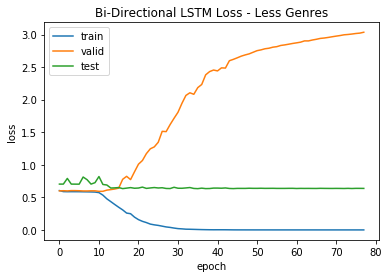

In [29]:
# plot loss (error)
plt.plot(all_loss)
plt.plot(all_val_loss)
plt.plot(test_err)
plt.title("Bi-Directional LSTM Loss - Less Genres")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'test'], loc='upper left')
plt.show()

### Get Final Predictions
<ul>
    <li>Show Multi-Level Metrics</li>
    <li>Show percentage of correctly labeled predicitons</li>
    <li>Show accuracy, precision, and recall for each genre</li>
</ul>

In [30]:
predictions = nn_output_to_predictions(model_lstm.predict(x_test_seq))

In [31]:
y_test[:,0].sum()

189

In [32]:
predictions[:,0].sum()

172

In [33]:
multi_label_accuracy(y_test, predictions)

0.3626157407407409

In [34]:
multi_label_precision(y_test, predictions)

0.46701388888888906

In [35]:
multi_label_recall(y_test, predictions)

0.5316550925925925

In [36]:
print("Percent of correctly decided label decisions: " + str(100* (1-hamming_loss(y_test, predictions))))

Percent of correctly decided label decisions: 65.68287037037037


In [37]:
get_per_label_metrics(y_test, predictions)

Accuruacy for Action-Adventure: 0.6545138888888888
Precision for Action-Adventure: 0.47093023255813954
Recall for Action-Adventure: 0.42857142857142855

Accuruacy for Romance: 0.7413194444444444
Precision for Romance: 0.3068181818181818
Recall for Romance: 0.23478260869565218

Accuruacy for Horror-Thriller: 0.5972222222222222
Precision for Horror-Thriller: 0.43416370106761565
Recall for Horror-Thriller: 0.6256410256410256

Accuruacy for Comedy: 0.6215277777777778
Precision for Comedy: 0.4406779661016949
Recall for Comedy: 0.39593908629441626

Accuruacy for Science Fiction: 0.75
Precision for Science Fiction: 0.28125
Recall for Science Fiction: 0.2647058823529412

Accuruacy for Drama: 0.5763888888888888
Precision for Drama: 0.5575447570332481
Recall for Drama: 0.754325259515571

